In [14]:
# Imports
import utils.data_exploration as de

import numpy as np
import pandas as pd
import numexpr as ne
import matplotlib.pyplot as plt
from torchmetrics.functional.classification import binary_stat_scores


In [15]:
# Load Dataframe and confusion matrix
def load_df(i):
    df = pd.read_parquet(f"parquet_data/R{i}_df.parquet")
    CM_df = pd.read_parquet(f"parquet_data/R{i}_CM_df.parquet")
    CM = np.load(f"parquet_data/R{i}_CM.npy", allow_pickle=False)

    return df, CM_df, CM


df, CM_df, CM = load_df(2)
conf_matrix_total = np.sum(CM, axis=0)
metrics = de.conf_matrix_metrics(conf_matrix_total)

FALSE POSITIVE
Total 
       window idx  event_idx  Pred probability  Pred label  True label Result
1964           42         31            51.67%           1           0     FP
1965           43         31            51.66%           1           0     FP
7542           40        121            50.17%           1           0     FP
7543           41        121            52.19%           1           0     FP
7544           42        121            50.68%           1           0     FP
7556           54        121            51.81%           1           0     FP
7557           55        121            83.67%           1           0     FP
7558           56        121            86.55%           1           0     FP
7559           57        121            83.02%           1           0     FP
7560           58        121            78.20%           1           0     FP
7561           59        121            77.77%           1           0     FP
7562           60        121            77

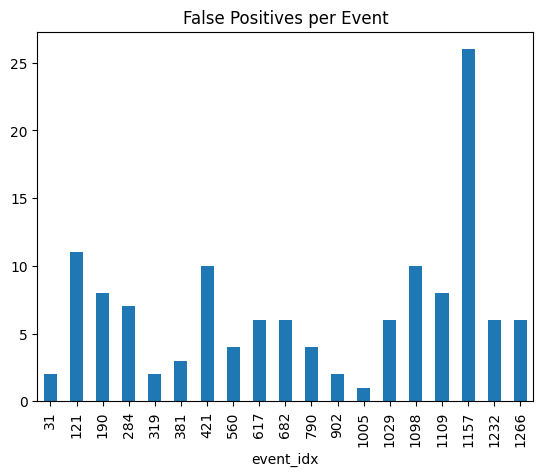

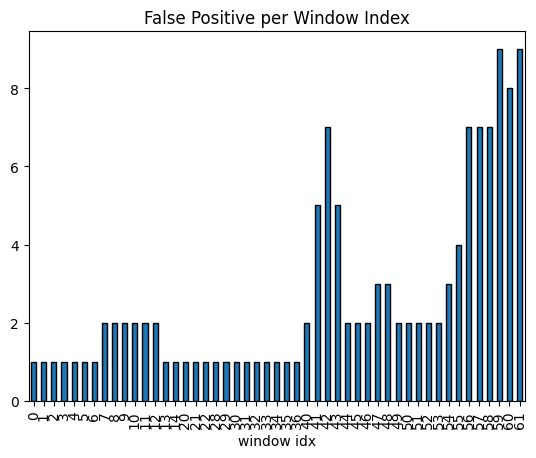

LIMITS RANGE range(5, 11)


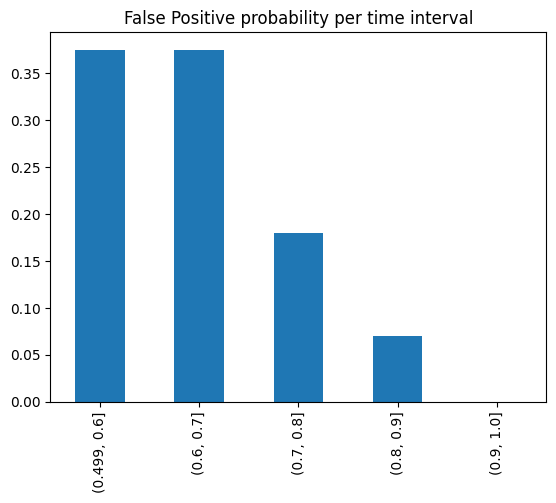

FALSE NEGATIVES
Total 
       window idx  event_idx  Pred probability  Pred label  True label Result
810             4         13            34.14%           0           1     FN
811             5         13            35.97%           0           1     FN
812             6         13            40.86%           0           1     FN
813             7         13            40.88%           0           1     FN
814             8         13            46.60%           0           1     FN
868             0         14            45.72%           0           1     FN
869             1         14            18.74%           0           1     FN
870             2         14            49.76%           0           1     FN
1116            0         18             5.36%           0           1     FN
1117            1         18            11.25%           0           1     FN
1118            2         18            23.23%           0           1     FN
1142           26         18            4

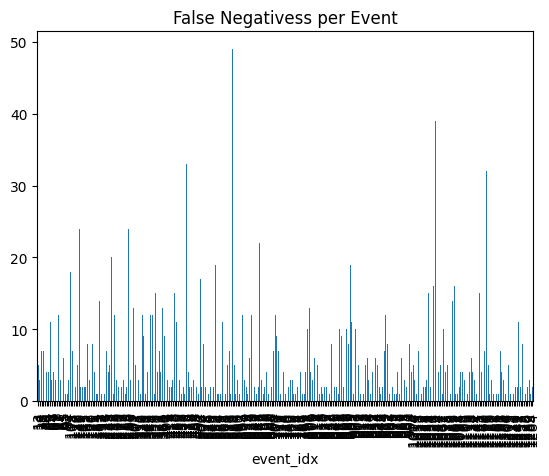

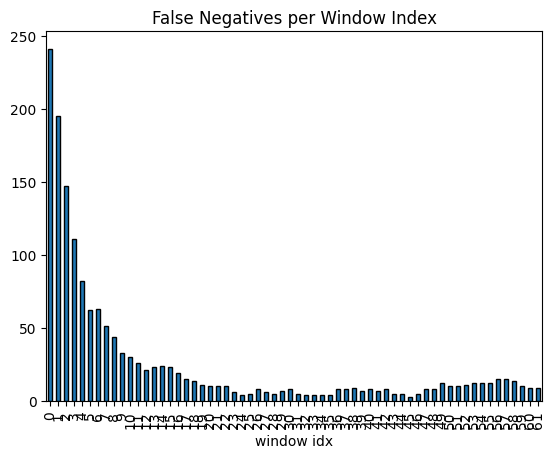

LIMITS RANGE range(0, 6)


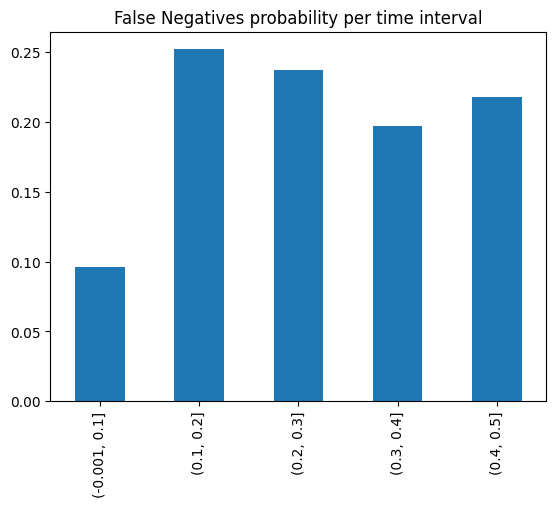

In [59]:
false_positive = df[df["Result"] == "FP"]
false_negative = df[df["Result"] == "FN"]


def false_events_plots(false_events: pd.DataFrame, Title: str):
    # df and plots settings
    pd.set_option("display.float_format", "{:.2%}".format)
    pd.options.plotting.backend = "matplotlib"
    pd.set_option("display.max_rows", 2000)

    false_events_plot = false_events.groupby(["window idx"])["window idx"].count()

    if len(false_events_plot) > 0:
        print(Title.upper())
        print(f"Total ")
        print(false_events)
        false_events.groupby(["event_idx"])["event_idx"].count().plot(kind="bar")
        plt.title(f"{Title}s per Event")
        plt.show()

        false_events_plot.plot(kind="bar", edgecolor="black")
        plt.title(f"{Title} per Window Index")
        plt.show()

        limits_range = (
            range(6) if (false_events["Pred probability"].min() < 0.5) else range(5, 11)
        )
        print(f"LIMITS RANGE {limits_range}")
        false_events["Pred probability"].value_counts(
            bins=[i * 0.1 for i in limits_range], sort=False, normalize=True
        ).plot(kind="bar")
        plt.title(f"{Title} probability per time interval")
        plt.show()


false_events_plots(false_positive, "False Positive")
false_events_plots(false_negative, "False Negatives")

In [17]:
print(conf_matrix_total)
metrics = de.conf_matrix_metrics(conf_matrix_total)
de.print_metrics(metrics)
de.plot_confusion_matrix(metrics)

[45545   128 33352  1575 47120]
Total Samples:................80600
True Positives:...............45545
False Positives:.............. 128
True Negatives:...............33352
False Negatives:..............1575
Accuracy:.....................  97.9%
True Positive Rate:...........  96.7%
False Positive Rate:..........   0.4%
True Negative Rate:...........  99.6%
Positive Predictive Value:....  99.7%


In [5]:
df[(df["Result"] == "FP") & (df["Pred probability"] > 0.8)].groupby(df["window idx"])

In [6]:
p = df[df["True label"] == 1].event_idx.value_counts().shape[0]
n = df[df["True label"] == 0].event_idx.value_counts().shape[0]
print(f"Fault Events (True): {p} \nNon Fault Events (False): {n}")


def test_result_count(
    df: pd.DataFrame, expected_result: str, Label: int, includes=True
) -> int:
    if includes:
        test_result_df = df[
            (df["Result"] == expected_result) & (df["True label"] == Label)
        ]
    else:
        test_result_df = df[
            (df["Result"] != expected_result) & (df["True label"] == Label)
        ]

    test_result_count_per_event = test_result_df["event_idx"].value_counts()
    return test_result_count_per_event.shape[0]


tp = test_result_count(df, "TP", 1)
fp = test_result_count(df, "FP", 0)
tn = n - fp
fn = p - tp
print(
    f"True Positives: {tp} \nFalse Positives: {fp} \nTrue Negatives: {tn} \nFalse Negatives: {fn}"
)

metrics = de.conf_matrix_metrics(np.array([tp, fp, tn, fn, tp + fn]))
de.print_metrics(metrics)
de.plot_confusion_matrix(metrics)

Fault Events (True): 760 
Non Fault Events (False): 540
True Positives: 760 
False Positives: 19 
True Negatives: 521 
False Negatives: 0
Total Samples:................1300
True Positives:............... 760
False Positives:..............  19
True Negatives:............... 521
False Negatives:..............   0
Accuracy:.....................  98.5%
True Positive Rate:........... 100.0%
False Positive Rate:..........   3.5%
True Negative Rate:...........  96.5%
Positive Predictive Value:....  97.6%


In [47]:
print(false_negative["Pred probability"].apply(np.floor).min())
print(false_negative["Pred probability"].min())
print(false_negative["Pred probability"].round(3).min())
print(false_negative["Pred probability"].max())
print(false_positive["Pred probability"].apply(np.floor).min())
print(false_positive["Pred probability"].max())
print(false_positive["Pred probability"].round(3).max())

min_range = range(6) if (false_negative["Pred probability"].min() < 0.5) else range(5, 11)
print(min_range)

0.0
0.01651462
0.017
0.49966756
0.0
0.880861
0.881
range(0, 6)


FALSE POSITIVE
Total 
       window idx  event_idx  Pred probability  Pred label  True label Result
1964           42         31            51.67%           1           0     FP
1965           43         31            51.66%           1           0     FP
7542           40        121            50.17%           1           0     FP
7543           41        121            52.19%           1           0     FP
7544           42        121            50.68%           1           0     FP
7556           54        121            51.81%           1           0     FP
7557           55        121            83.67%           1           0     FP
7558           56        121            86.55%           1           0     FP
7559           57        121            83.02%           1           0     FP
7560           58        121            78.20%           1           0     FP
7561           59        121            77.77%           1           0     FP
7562           60        121            77

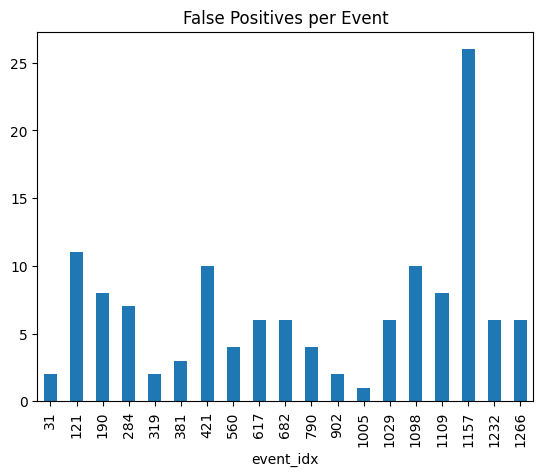

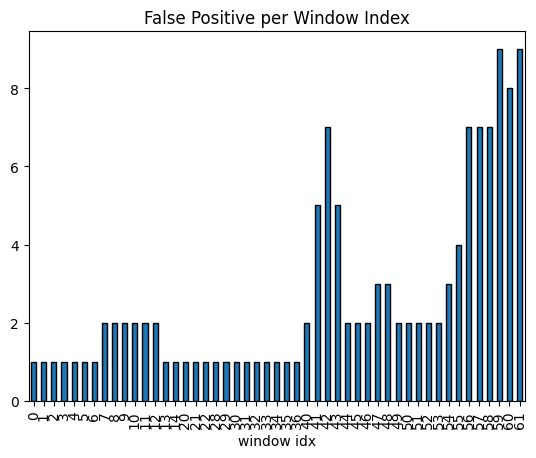

LIMITS RANGE range(5, 11)


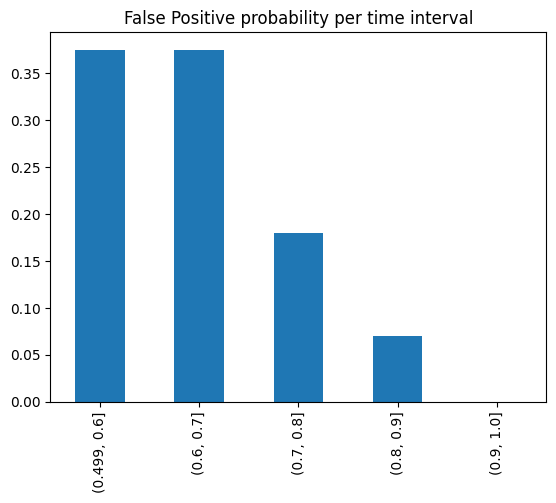

FALSE NEGATIVES
Total 
       window idx  event_idx  Pred probability  Pred label  True label Result
810             4         13            34.14%           0           1     FN
811             5         13            35.97%           0           1     FN
812             6         13            40.86%           0           1     FN
813             7         13            40.88%           0           1     FN
814             8         13            46.60%           0           1     FN
868             0         14            45.72%           0           1     FN
869             1         14            18.74%           0           1     FN
870             2         14            49.76%           0           1     FN
1116            0         18             5.36%           0           1     FN
1117            1         18            11.25%           0           1     FN
1118            2         18            23.23%           0           1     FN
1142           26         18            4

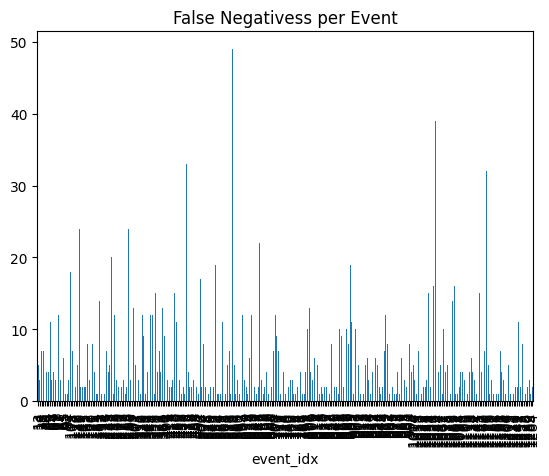

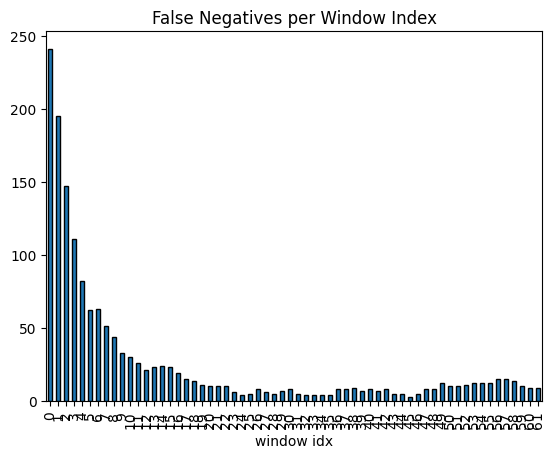

LIMITS RANGE range(0, 6)


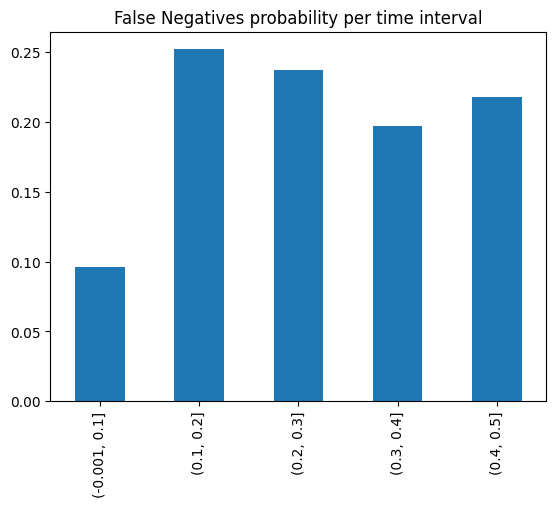

In [58]:
false_positive = df[df["Result"] == "FP"]
false_negative = df[df["Result"] == "FN"]


def false_events_plots(false_events: pd.DataFrame, Title: str):
    # df and plots settings
    pd.set_option("display.float_format", "{:.2%}".format)
    pd.options.plotting.backend = "matplotlib"
    pd.set_option("display.max_rows", 2000)

    false_events_plot = false_events.groupby(["window idx"])["window idx"].count()

    if len(false_events_plot) > 0:
        print(Title.upper())
        print(f"Total ")
        print(false_events)
        false_events.groupby(["event_idx"])["event_idx"].count().plot(kind="bar")
        plt.title(f"{Title}s per Event")
        plt.show()

        false_events_plot.plot(kind="bar", edgecolor="black")
        plt.title(f"{Title} per Window Index")
        plt.show()

        limits_range = (
            range(6) if (false_events["Pred probability"].min() < 0.5) else range(5, 11)
        )
        print(f"LIMITS RANGE {limits_range}")
        false_events["Pred probability"].value_counts(
            bins=[i * 0.1 for i in limits_range], sort=False, normalize=True
        ).plot(kind="bar")
        plt.title(f"{Title} probability per time interval")
        plt.show()


false_events_plots(false_positive, "False Positive")
false_events_plots(false_negative, "False Negatives")